# Homework1 : Car Fuel


## Day 3

• 交差検証、ホールドアウト法などで汎化性能を確認する
• 欠測値と異常値を確認し、適切に処理する
• DAY2、3で学んだアルゴリズムを利用してモデルをつくり、DAY1宿題提出時の精度と比較する
• 交差検証によるパラメータチューニングを行う
• パラメータチューニング後のモデルによって、精度および結果の評価を行う
• その他、精度の向上ができるような処理に取り組み、精度を上げる

• できたところまでをNotebookでまとめ、宿題として提出する

• 前回から取り組んだ内容・工夫、精度がどのように変化したかのコメントを
Notebookに含めること

## Feedback

- 実際にデータと回帰した結果をプロットしながら検討を進めていて，素晴らしいです！
- 正則化パラメータの検討も，係数と回帰した結果を並べてプロットしていてとてもわかりやすいですね！
- 次に向けた方針として，質的変数をどのように数値化するかを考えてみましょう
- また，training dataのプロットを見ると，直線では当てることが難しい部分があります（speedが-2 ~ -1のあたり）のでこのデータの扱いを考えてみましょう
- 取り除く？あるいは非線形の関係が取れるモデル（木モデルやNeural Network）を使って当てに行く？
- CVして最も精度が良かったElasticNetのセッティングで学習した後の係数はどのようになりましたか？そこから有用な特徴が何になるのかを分析してみましょう


In [ ]:
質的変数をどのように数値化するかを考えてみましょう

すでにone-hotにされている？後で確認。

直線では当てることが難しい部分があります（speedが-2 ~ -1のあたり）のでこのデータの扱いを考えてみましょう
取り除く？あるいは非線形の関係が取れるモデル（木モデルやNeural Network）を使って当てに行く？

Neural Networkを使ってみる。

In [ ]:
- CVして最も精度が良かったElasticNetのセッティングで学習した後の係数はどのようになりましたか？そこから有用な特徴が何になるのかを分析してみましょう

前回の結果で一番良かったもの
E10
Cross Validation MAE = 0.627 (alpha : 1.000000e+00, ll_ratio : 0.75)
Cross Validation MAE = 0.627 (alpha : 1.000000e+00, ll_ratio : 1.0)

SP90
Cross Validation MAE = 0.706 (alpha : 1.000000e-01, ll_ratio : 1.0)

いずれもl1_ratioが高め、つまりリッジよりもラッソが有益で、幾つかの説明変数は不要にできる可能性が高い。
このことからステップワイズで削ってみる。（説明変数はあまり多くないので全パターンも試せるけれども。）

In [136]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from keras.utils import to_categorical
import warnings
from sklearn.feature_selection import RFECV
from itertools import combinations
warnings.filterwarnings('ignore')


def standalization(d):
    df = pd.DataFrame(d,dtype=float)
    stdsc = StandardScaler()
    return stdsc.fit_transform(df.values)

df_flue = pd.read_csv("data/measurements.csv")
# "refill liters,refill gas" are ignored.
df_flue = df_flue.filter(items=['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 
                                'gas_type','AC','rain', 'sun'])

# Replace the type
for k in ["consume","temp_inside", "distance"]:
    df_flue[k] = df_flue[k].str.replace(",", ".").astype(float)

df_e10 = df_flue[df_flue['gas_type'].str.contains('E10')].dropna(how='any')
df_sp98 = df_flue[df_flue['gas_type'].str.contains('SP98')].dropna(how='any')

df_flue.describe()


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


In [30]:
df_e10.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,21.095541,4.950955,43.566879,21.917197,10.031847,0.044586,0.101911,0.070064
std,20.495185,0.897976,14.154946,0.659854,6.379475,0.207053,0.303499,0.256071
min,1.700000,3.700000,14.000000,21.000000,-5.000000,0.000000,0.000000,0.000000
25%,12.000000,4.400000,35.000000,21.500000,6.000000,0.000000,0.000000,0.000000
50%,15.400000,4.800000,42.000000,21.500000,9.000000,0.000000,0.000000,0.000000
75%,21.100000,5.300000,51.000000,22.500000,14.000000,0.000000,0.000000,0.000000
max,130.300000,10.800000,88.000000,25.000000,27.000000,1.000000,1.000000,1.000000


In [31]:
df_sp98.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,18.866667,4.906849,40.803653,21.938356,12.278539,0.105023,0.141553,0.091324
std,24.625703,1.133679,13.302507,1.201906,7.393901,0.307285,0.349389,0.288730
min,1.300000,3.300000,16.000000,19.000000,-3.000000,0.000000,0.000000,0.000000
25%,11.800000,4.200000,32.000000,21.500000,7.000000,0.000000,0.000000,0.000000
50%,14.200000,4.700000,40.000000,22.000000,11.000000,0.000000,0.000000,0.000000
75%,18.200000,5.200000,48.000000,22.000000,17.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000


Cross Validation Try 1 / 5
MAE : 0.6103730082511902
Cross Validation Try 2 / 5
MAE : 0.9695136845111848
Cross Validation Try 3 / 5
MAE : 0.45587320020121896
Cross Validation Try 4 / 5
MAE : 0.5829273546895675
Cross Validation Try 5 / 5
MAE : 0.5955228990124118
Cross Validation MAE = 0.643


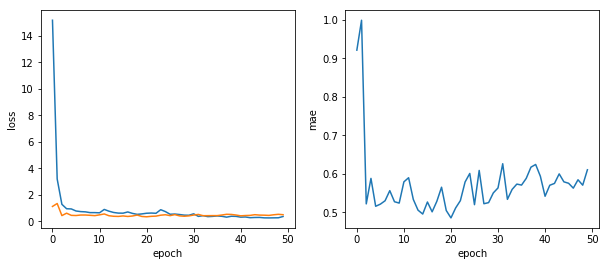

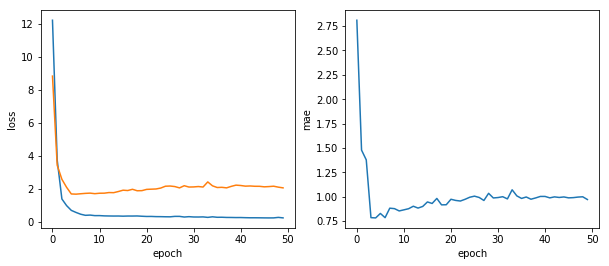

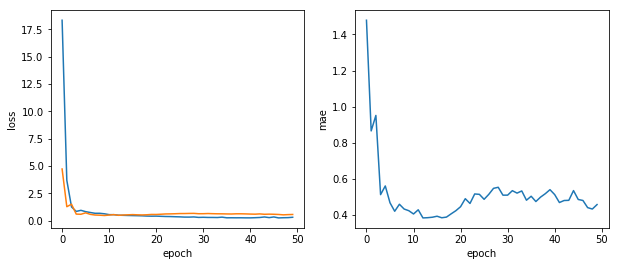

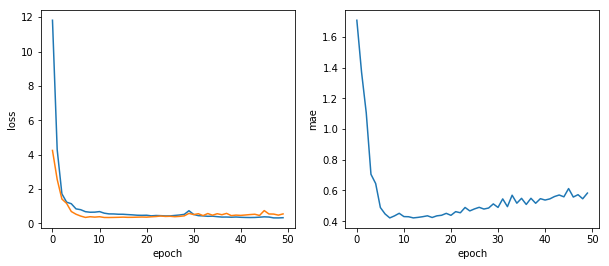

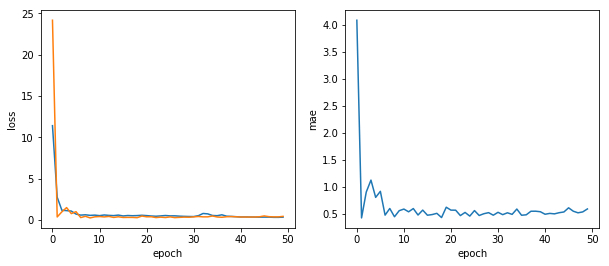

In [133]:
def run(X, y):    
    X = standalization(X)
    # Neural Network + CrossValidation

    # ------ 最適化手法 ------
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    # rms = RMSprop(lr=0.01)
    # adag = Adagrad(lr=0.01)
    # adad = Adadelta(lr=0.01)
    # adam = Adam(lr=0.01)
    # -----------------------------

    n_split = 5
    cross_valid_mae = 0
    split_num = 1

    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        model = Sequential()
        model.add(Dense(7, activation='relu', input_dim=7))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1)) #, activation='softmax')
        
        # 回帰にはcategorical_crossentropyではなくこっち。
        model.compile(loss='mean_squared_error',
                  optimizer=sgd,
                  metrics=['mae'])

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        fit = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=20,
                        validation_data=(X_test, y_test),
                       verbose=0)

        
        print(f"Cross Validation Try {split_num} / {n_split}")
        # テストデータに対するMAEを計算
        y_pred_test = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred_test)
        print(f"MAE : {mae}")

        fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
        # グラフ化
        df = pd.DataFrame(fit.history)
        axL.plot(df[["loss", "val_loss"]])
        axL.set_ylabel("loss")
        axL.set_xlabel("epoch")

        axR.plot(df[["val_mean_absolute_error"]])
        axR.set_ylabel("mae")
        axR.set_xlabel("epoch")
        fig.show()

        cross_valid_mae += mae #後で平均を取るためにMAEを加算
        split_num += 1

    # MAEの平均値を最終的な汎化誤差値とする
    final_mae = cross_valid_mae / n_split
    print("Cross Validation MAE = %s"% (round(final_mae, 3)))

x_keys = ["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]
run(df_e10[x_keys].values, df_e10["consume"].values)


Cross Validation Try 1 / 5
MAE : 0.8570529981092975
Cross Validation Try 2 / 5
MAE : 0.8709038019180299
Cross Validation Try 3 / 5
MAE : 0.5566222234205767
Cross Validation Try 4 / 5
MAE : 0.37679549672386853
Cross Validation Try 5 / 5
MAE : 0.5524256284846816
Cross Validation MAE = 0.643


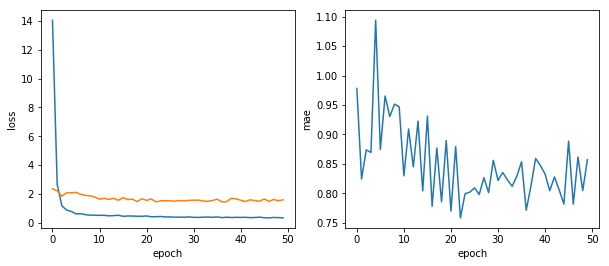

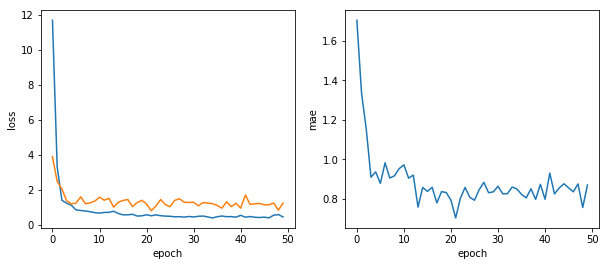

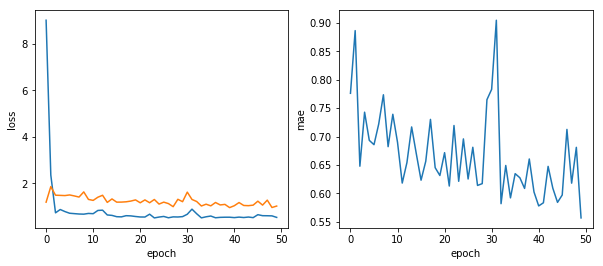

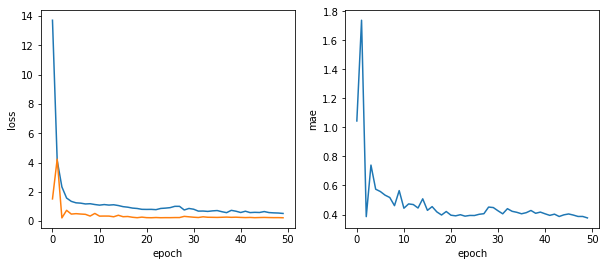

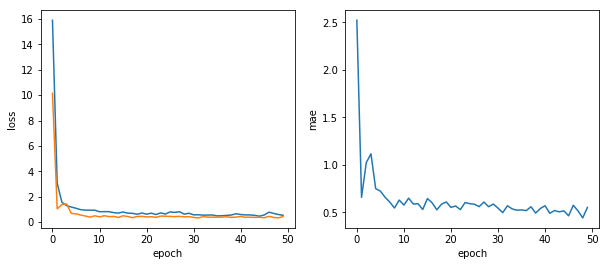

In [134]:
run(df_sp98[x_keys].values, df_sp98["consume"].values)

In [138]:
    # ニューラルネットワークとステップワイズを使おうとしたが、kerasとscikit-learnの組み合わせになり、うまく動かない。
    # TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x13942a0b8>'
    # (type <class 'keras.engine.sequential.Sequential'>): 
    # it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

def run2(X, y):    
    X = standalization(X)
    # Neural Network + StepWise

    # ------ 最適化手法 ------
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)

    model = Sequential()
    model.add(Dense(7, activation='relu', input_dim=7))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1)) #, activation='softmax')

    model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['mae'])

    rfecv = RFECV(model, cv=10, scoring='neg_mean_absolute_error')
    
    # fitで特徴選択を実行
    rfecv.fit(X, y)
    

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x13942a0b8>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [152]:
# 前回実行したエラスティックネットからラッソを抽出して、ステップワイズをしようとしたが
# 独自拡張しないと不可。
# => RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes
# https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
def run3(X, y):
    X = standalization(X)

    alpha = 1e-1
    degree = 10
    la = Lasso(alpha=alpha,max_iter=1e2)
    estimator = make_pipeline(PolynomialFeatures(degree), la)
    rfecv = make_pipeline(estimator, cv=2, scoring='neg_mean_absolute_error')
    rfecv.fit(X, y)
    
    print('Feature ranking: \n{}'.format(rfecv.ranking_))
    print('Support: \n{}'.format(rfecv.support_))
    remove_idx = ~rfecv.support_
    print('remove_idx: \n{}'.format(remove_idx))
    remove_feature = train_data.columns[remove_idx]
    print('remove_feature: \n{}'.format(remove_feature))

x_keys = ["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]
run3(df_e10[x_keys].values, df_e10["consume"].values)


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [151]:
def trywithkey(X, y, keys):    
    X = standalization(X)

    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    n_split = 5
    cross_valid_mae = 0
    print("Start keys : %s" % keys)
    print()

    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        model = Sequential()
        model.add(Dense(len(keys), activation='relu', input_dim=len(keys)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error',
                  optimizer=sgd,
                  metrics=['mae'])

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        fit = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=20,
                        validation_data=(X_test, y_test),
                        verbose=0)
        
        y_pred_test = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred_test)

        cross_valid_mae += mae
        print(".", end =" ")

    final_mae = cross_valid_mae / n_split
    print("\nCross Validation MAE = %s"% round(final_mae, 3))

# 非常に時間がかかるがやってみたかった、全組み合わせ
# さすがに時間がかかりすぎたのでスキップ
def run4(X, y):
    x_keys = ["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]
    for n in range(1, len(x_keys) + 1):
        print(f"Start for {n} combinations..")
        for keys in combinations(x_keys, n):
            keys = list(keys)
            trywithkey(X[keys].values, y.values, keys)
    
run4(df_e10, df_e10["consume"])


start for 1 combinations..
Start keys : ['distance']
. . . . . 
Cross Validation MAE = 0.64
Start keys : ['speed']
. . . . . 
Cross Validation MAE = 0.633
Start keys : ['temp_inside']
. . . . . 
Cross Validation MAE = 0.621
Start keys : ['temp_outside']
. . . . . 
Cross Validation MAE = 0.644
Start keys : ['AC']
. . . . . 
Cross Validation MAE = 0.622
Start keys : ['rain']
. . . . . 
Cross Validation MAE = 0.632
Start keys : ['sun']
. . . . . 
Cross Validation MAE = 0.639
start for 2 combinations..
Start keys : ['distance', 'speed']
. . . . . 
Cross Validation MAE = 0.653
Start keys : ['distance', 'temp_inside']
. . . . . 
Cross Validation MAE = 0.713
Start keys : ['distance', 'temp_outside']
. . . . . 
Cross Validation MAE = 0.631
Start keys : ['distance', 'AC']
. . . . . 
Cross Validation MAE = 0.61
Start keys : ['distance', 'rain']
. . . . . 
Cross Validation MAE = 0.611
Start keys : ['distance', 'sun']
. . . . . 
Cross Validation MAE = 0.636
Start keys : ['speed', 'temp_inside']
. 

KeyboardInterrupt: 

部分的には以下のkeyを解として得られた。これは前回の以下のデータを超える。

前回データ
Cross Validation MAE = 0.627 (alpha : 1.000000e+00, ll_ratio : 1.0)

今回のデータ
Start keys : ['distance', 'speed', 'temp_inside', 'temp_outside']
. . . . . 
Cross Validation MAE = 0.558

In [163]:

def evaluate(X, y, keys):    
    X = standalization(X)

    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    n_split = 5
    cross_valid_mae = 0
    print("Start with keys : %s" % keys, end =" ")

    for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
        model = Sequential()
        model.add(Dense(len(keys), activation='relu', input_dim=len(keys)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error',
                  optimizer=sgd,
                  metrics=['mae'])

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        fit = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=20,
                        validation_data=(X_test, y_test),
                        verbose=0)
        
        y_pred_test = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred_test)

        cross_valid_mae += mae
        print(".", end =" ")

    final_mae = cross_valid_mae / n_split
    print("Done \nCross Validation MAE = %s"% round(final_mae, 3))
    return final_mae

# ライブラリが動かなかったので簡単にステップワイズを自作
def stepwise(X, y, x_keys):
    if len(x_keys) == 1:
        print("Finish stepwise")
        print(x_keys)
        return x_keys

    current = evaluate(X[x_keys].values, y.values, x_keys)
    result = {}
    for keys in combinations(x_keys, len(x_keys) - 1):
        keys = list(keys)       
        dropped_key = list(set(x_keys) - set(keys))[0]
        score = evaluate(X[keys].values, y.values, keys)
        result[dropped_key] = score
    print("Result")
    print(result)
    if current < min(result.values()):
        print("Finish stepwise")
        print(x_keys)
        return x_keys
    else:
        min_score, min_key = min((score, key) for key, score in result.items())
        new_keys = [k for k in x_keys if k != min_key]
        print("Continue stepwise")
        print("dropped : %s " % min_key)
        return stepwise(X, y, new_keys)

def run5(X, y):
#    x_keys = ["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]
#    x_keys = ["distance", "speed"]
    x_keys = ["distance", "speed", "temp_inside", "temp_outside"]
    stepwise(X, y, x_keys)
        
run5(df_e10, df_e10["consume"])


Start with keys : ['distance', 'speed', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.603
Start with keys : ['distance', 'speed', 'temp_inside'] . . . . . Done 
Cross Validation MAE = 0.59
Start with keys : ['distance', 'speed', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.619
Start with keys : ['distance', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.653
Start with keys : ['speed', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.634
Result
{'temp_outside': 0.5904908794356931, 'temp_inside': 0.6186894333170306, 'speed': 0.6532236831226657, 'distance': 0.6342127658474831}
Continue stepwise
dropped : temp_outside 
Start with keys : ['distance', 'speed', 'temp_inside'] . . . . . Done 
Cross Validation MAE = 0.604
Start with keys : ['distance', 'speed'] . . . . . Done 
Cross Validation MAE = 0.611
Start with keys : ['distance', 'temp_inside'] . . . . . Done 
Cross Validation MAE = 0.661
Start with keys

In [ ]:
run5(df_sp98, df_sp98["consume"])

Start with keys : ['distance', 'speed', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.617
Start with keys : ['distance', 'speed', 'temp_inside'] . . . . . Done 
Cross Validation MAE = 0.636
Start with keys : ['distance', 'speed', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.592
Start with keys : ['distance', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.654
Start with keys : ['speed', 'temp_inside', 'temp_outside'] . . . . . Done 
Cross Validation MAE = 0.643
Result
{'temp_outside': 0.6363135804888059, 'temp_inside': 0.5918526451179392, 'speed': 0.6543250473861211, 'distance': 0.6428833931848312}
Continue stepwise
dropped : temp_inside 
Start with keys : ['distance', 'speed', 'temp_outside'] . . . 